# Web Scrapping

In [ ]:
from selenium.common import NoSuchElementException, TimeoutException
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
import time
import chromedriver_autoinstaller
"""
from flask import Flask, request

app = Flask(__name__)

my_place_id = ""

@app.route("/get_place_details", methods=["POST"])
def get_place_details():
    global my_place_id
    data = request.get_json()
    my_place_id = data["place_id"]
    return "Received place id: " + my_place_id

if __name__ == "__main__":
    app.run(port=5000)
"""
#my_place_id = "ChIJj61dQgK6j4AR4GeTYWZsKWw"
#google_url = "https://www.google.com/maps/place/?q=place_id:"+my_place_id
google_url = "https://www.google.com/maps/place/Googleplex/@37.4220656,-122.0862784,17z/data=!3m1!4b1!4m6!3m5!1s0x808fba02425dad8f:0x6c296c66619367e0!8m2!3d37.4220656!4d-122.0840897!16zL20vMDNiYnkx?entry=ttu"

chromedriver_autoinstaller.install()

driver = webdriver.Chrome()

driver.set_window_size(1024, 600)
driver.maximize_window()

driver.get(google_url)

names = []
rating = []
dates = []
comments = []

try:
    # Wait for consent page to load
    accept_all_button = WebDriverWait(driver, 10).until(
        # By css_selector (1 or more classes) is more robust choice because by class_name can only handle 1 class
        EC.presence_of_element_located((By.CSS_SELECTOR, "[jsname='b3VHJd']"))
    )
    # Accept cookies because they are good
    accept_all_button.click()
except:
    print("An error occurred when trying to accept Google's terms of conditions.")

# get numbers of comments
total_reviews = 1
try:
    # Wait for consent page to load
    reviews_info = WebDriverWait(driver, 10).until(
        # By css_selector (1 or more classes) is more robust choice because by class_name can only handle 1 class
        EC.presence_of_element_located((By.CSS_SELECTOR, ".F7nice"))
    )
    # get all the spans
    span_elements = reviews_info.find_elements(By.TAG_NAME, 'span')
    print(len(span_elements))
    total_reviews = int(span_elements[8].text[1:-1].replace(",", ""))
    print(total_reviews)
    if total_reviews > 500:
        total_reviews = 500
    print(total_reviews)
except:
    print("Couldn't get number of reviews.")

# get to reviews
try:
    reviews_button = WebDriverWait(driver, 10).until(
        # EC.presence_of_element_located((By.CSS_SELECTOR, "[data-tab-index='1']"))
        # EC.presence_of_element_located((By.CSS_SELECTOR, "[aria-label*='Review']"))
        EC.presence_of_element_located((By.CSS_SELECTOR, "[jslog='145620;track:click;']"))
    )
    reviews_button.click()
except:
    print("An error occurred when trying to get to reviews.")

# scroll until the end
try:
    scrollable_div = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, ".m6QErb.DxyBCb.kA9KIf.dS8AEf"))
    )
    last_height = driver.execute_script("return arguments[0].scrollHeight", scrollable_div)
    # get number of currently loaded comments
    n_comment_divs = len(driver.find_elements(By.CSS_SELECTOR, ".jftiEf.fontBodyMedium "))
    # limits to 500 reviews
    while n_comment_divs < total_reviews:
        # scroll to the bottom
        driver.execute_script(
            "arguments[0].scrollTop = arguments[0].scrollHeight", scrollable_div
        )
        # wait for the page to load
        time.sleep(1.3)
        # recalculate number of loaded divs
        try:
            # wait for the number of comments to change with a maximum wait time of 10 seconds
            WebDriverWait(driver, 10).until(lambda x: len(x.find_elements(By.CSS_SELECTOR, ".jftiEf.fontBodyMedium ")) > n_comment_divs)
            # recalculate number of loaded divs
            n_comment_divs = len(driver.find_elements(By.CSS_SELECTOR, ".jftiEf.fontBodyMedium "))
        except TimeoutException:
            # if after 10 seconds the number of comments hasn't changed, break
            break
        # calculate new scroll height and compare with the last scroll height
        new_height = driver.execute_script("return arguments[0].scrollHeight", scrollable_div)
        if new_height == last_height:
            break
        last_height = new_height
except:
    print("Couldn't scroll...")

# open the comments fully (see more)
try:
    # gather all see more buttons and click them
    all_see_more_buttons = driver.find_elements(By.CSS_SELECTOR, ".w8nwRe.kyuRq")
    for button in all_see_more_buttons:
        button.click()
except:
    print("Couldn't click all see more buttons.")

# extract text
try:
    comment_divs = driver.find_elements(By.CSS_SELECTOR, ".jftiEf.fontBodyMedium ")
    # there is necessarily a name, rating and a date but not comment
    for comment in comment_divs:
        # get name
        names.append(comment.find_element(By.CLASS_NAME, "d4r55 ").text)
        # get review but on the case of hotels, it might be different disposition
        try:
            rating.append(comment.find_element(By.CLASS_NAME, "kvMYJc").get_attribute("aria-label"))
        except:
            rating.append(comment.find_element(By.CLASS_NAME, "fzvQIb").text)
        # get dates, in case of hotels, might be different
        try:
            dates.append(comment.find_element(By.CLASS_NAME, "rsqaWe").text)
        except:
            date_element = comment.find_element(By.CLASS_NAME, "xRkPPb")
            date_text = driver.execute_script('return arguments[0].firstChild.textContent;', date_element).strip()
            dates.append(date_text)
        # verify that there is comment and add, else add empty string
        text = ""
        try:
            myened_element = comment.find_element(By.CLASS_NAME, "MyEned")
            text = myened_element.find_element(By.CLASS_NAME, "wiI7pd").text
        except NoSuchElementException:
            text = ""
        comments.append(text)
except:
    print("Something happened when trying to parse reviews...")

finally:
    driver.quit()

zipped = list(zip(names, rating, dates, comments))
dictionary = {key: (v1, v2, v3) for key, v1, v2, v3 in zipped}

print(dictionary)

11
10065
500
Couldn't scroll...
Couldn't click all see more buttons.
Something happened when trying to parse reviews...
{}


In [ ]:
import csv

# Exporter le dict vers le fichier csv (OVERWRITE)
import csv
chemin_fichier = 'data.csv'

# Écrire le dictionnaire dans le fichier CSV
with open(chemin_fichier, 'w', newline='', encoding='utf-8') as fichier_csv:
    writer = csv.writer(fichier_csv, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Name', 'grading', 'date', 'Text'])  # En-tête des colonnes

    for nom, commentaire in dictionary.items():
        writer.writerow([nom, commentaire[0], commentaire[1], commentaire[2]])
"""
# Add par la suite pour la création d'un gros dataset pour le training du modèle
chemin_fichier = 'data.csv'

with open(chemin_fichier, 'a', newline='', encoding='utf-8') as fichier_csv:
    writer = csv.writer(fichier_csv, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    for nom, commentaire in dictionary.items():
        writer.writerow([nom, commentaire[0], commentaire[1], commentaire[2]])
"""

'\n# Add par la suite pour la création d\'un gros dataset pour le training du modèle\nchemin_fichier = \'data.csv\'\n\nwith open(chemin_fichier, \'a\', newline=\'\', encoding=\'utf-8\') as fichier_csv:\n    writer = csv.writer(fichier_csv, delimiter=\',\', quotechar=\'"\', quoting=csv.QUOTE_MINIMAL)\n\n    for nom, commentaire in dictionary.items():\n        writer.writerow([nom, commentaire[0], commentaire[1], commentaire[2]])\n'

# Data Cleaning


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import numpy as np

In [ ]:
# Convertir le dictionnaire en DataFrame

# df = pd.read_csv('dataset1.csv', sep=';')
df = pd.read_csv('data.csv')
df = df.dropna()

# Remplacer les valeurs dans grading par des int
df["grading"] = [int(x[0]) if x[0].isdigit() and "/" not in x else int(5*float(x.split('/')[0])/float(x.split('/')[1])) for x in df["grading"]]

# Remplace date par un dictionnaire {months: number, years: number}
def transform_date(date):
    weeks_or_days = ['week', 'day', 'semaine', 'jour']
    date_array = date.split()
    if any(word in date_array for word in weeks_or_days):
        return 0
    elif 'month' in date or 'mois' in date:
        if date_array[0].isdigit():
            return int(date_array[0])
        return 1
    elif date_array[0].isdigit():
        return int(date_array[0])*12
    return 12

df["date"] = df["date"].apply(transform_date)

df.index_name = 'ID'
# Renommer la colonne d'index en "ID"
df = df.rename_axis('ID').reset_index()
df.set_index('ID', inplace=True)
# Ajouter la colonne Language à la DataFrame

# Pour que les détections soient consistent
DetectorFactory.seed = 0
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

df['Language'] = df['Text'].apply(detect_language)
df.drop(df.loc[df['Language'] == 'unknown'].index, inplace=True)

df

,Name,grading,date,Text,Language
ID,,,,,
0,Reezaane Bundhoo,4,12,"Delicious cakes, hot/cold beverages and great ...",en
1,Akram Althawbani,5,3,Best place but it's still camels man opinion. ...,en
2,Ibrahim Sobh,4,1,"Amazing place to buy bread and sweets , always...",en
3,Mareike Engel,5,5,Love the baguette and croissant. Staff is alwa...,en
4,shrishail kurangi,3,6,All the items I have tried here are really gre...,en
...,...,...,...,...,...
5009,Ammellle Ammellle,5,48,Salle intimiste très agréable,fr
5010,Amélie Glorian,4,12,Ancien cinéma,fr
5012,jules qci,5,72,Bonne salle rien a dire,fr


## Translation

In [ ]:
"""#pip install google-cloud-translate==2.0.1
from google.cloud import translate_v2 as translate
import os, json
from dotenv import load_dotenv
load_dotenv()

CREDENTIALS = json.loads(os.environ.get('CREDENTIALS'))

if os.path.exists('credentials.json'):
    pass
else:
    with open('credentials.json', 'w') as credFile:
        json.dump(CREDENTIALS, credFile)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'credentials.json'

def translate_text(row):
    translate_client = translate.Client()

    text = row['Text']
    if isinstance(text, bytes):
        text = text.decode("utf-8")

    # Only translate the text if the language isn't 'en'.
    if row['Language'] != 'en':
        try:
            result = translate_client.translate(text, target_language='en')
            return pd.Series([result["translatedText"], 'en'])
        except Exception:
            return pd.Series([text, row['Language']])  # if translation fails, return original text and language
    else:
        return pd.Series([text, row['Language']])  # if text is already in English, return original text and language

df[['Text', 'Language']] = df.apply(translate_text, axis=1)
df
"""

from deep_translator import GoogleTranslator

def translate_text(df):
    for i, row in df.iterrows():
        if row['Language'] != 'en':
            text = row['Text']
            translated_text = GoogleTranslator(source='auto', target='en').translate(text)
            df.at[i, 'Text'] = translated_text
            df.at[i, 'Language'] = 'en'
    return df

# Apply the function to the DataFrame
df = translate_text(df)
df

KeyboardInterrupt: 

## EDA

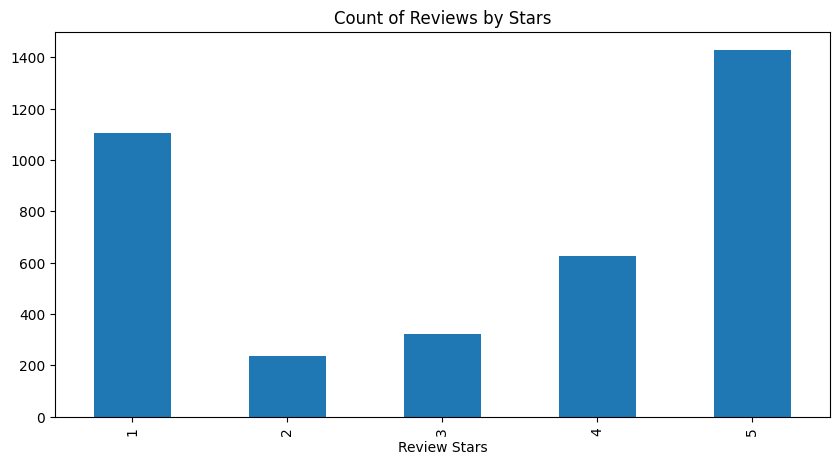

In [ ]:
ax = df['grading'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

# Sentiment Analysis

### Roberta

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer

In [ ]:
# Sentiment Analysis with Roberta
"""
nlp = pipeline("sentiment-analysis", model=f"cardiffnlp/twitter-roberta-base-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en':
        dict = pd.DataFrame(nlp(text))
        dict['ID'] = index
        res = pd.concat([res, dict], axis=0)
"""
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

nlp = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", tokenizer=tokenizer)

res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']

    # If the language is English and the token length doesn't exceed the limit
    if langue == 'en':
        tokens = tokenizer.encode(text, return_tensors='pt')

        if len(tokens[0]) <= 512:
            dict = pd.DataFrame(nlp(text))
            dict['ID'] = index
            res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('LABEL_0', 'NEGATIVE')
res['label'] = res['label'].replace('LABEL_1', 'NEUTRAL')
res['label'] = res['label'].replace('LABEL_2', 'POSITIVE')
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (roberta)", "score": "score (roberta)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df


,Name,grading,date,Text,Language,label (roberta),score (roberta)
ID,,,,,,,
0,Reezaane Bundhoo,4,12,"Delicious cakes, hot/cold beverages and great ...",en,POSITIVE,0.907862
1,Akram Althawbani,5,3,Best place but it's still camels man opinion. ...,en,POSITIVE,0.809464
2,Ibrahim Sobh,4,1,"Amazing place to buy bread and sweets , always...",en,NEUTRAL,0.368061
3,Mareike Engel,5,5,Love the baguette and croissant. Staff is alwa...,en,POSITIVE,0.991683
4,shrishail kurangi,3,6,All the items I have tried here are really gre...,en,NEGATIVE,0.392930
...,...,...,...,...,...,...,...
5009,Ammellle Ammellle,5,48,Very pleasant intimate room,en,POSITIVE,0.966187
5010,Amélie Glorian,4,12,old cinema,en,NEUTRAL,0.736137
5012,jules qci,5,72,Good room nothing to say,en,POSITIVE,0.725447


## nlptown/bert-base-multilingual-uncased-sentiment

In [ ]:
# Sentiment Analysis Bert-base-uncased
# Plusieurs langages disponibles (dont le français)
#English	150k
#Dutch	80k
#German	137k
#French	140k
#Italian	72k
#Spanish
# Il classifie les phrases en étoiles (1 à 5)
# Ce modèle est connu
"""
nlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en' or langue == 'fr' or langue == 'es' or langue == 'it' or langue == 'de' or langue == 'nl':

        tokens = tokenizer.encode(text, return_tensors='pt')

        if len(tokens[0]) <= 512:
            dict = pd.DataFrame(nlp(text))
            dict['ID'] = index
            res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('1 star', int(1))
res['label'] = res['label'].replace('2 stars', int(2))
res['label'] = res['label'].replace('3 stars', int(3))
res['label'] = res['label'].replace('4 stars', int(4))
res['label'] = res['label'].replace('5 stars', int(5))
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={'label': 'label (Bert), over 5', 'score': 'score (Bert)'})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df
"""
# print(df.isnull().sum())
# print(f"Negative: {df[df['label (roberta)'] == 'NEGATIVE'].count()}, Positive: {df[df['label (roberta)'] == 'POSITIVE'].count()}, Neutral: {df[df['label (roberta)'] == 'NEUTRAL'].count()}")


'\nnlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")\n\n# Run the polarity score on the entire dataset\nres = pd.DataFrame(columns=[\'label\', \'score\'])\nfor index, row in df.iterrows():\n    text = row[\'Text\']\n    langue = row[\'Language\']\n    if langue == \'en\' or langue == \'fr\' or langue == \'es\' or langue == \'it\' or langue == \'de\' or langue == \'nl\':\n\n        tokens = tokenizer.encode(text, return_tensors=\'pt\')\n\n        if len(tokens[0]) <= 512:\n            dict = pd.DataFrame(nlp(text))\n            dict[\'ID\'] = index\n            res = pd.concat([res, dict], axis=0)\n\n# Remplacement des valeurs\nres[\'label\'] = res[\'label\'].replace(\'1 star\', int(1))\nres[\'label\'] = res[\'label\'].replace(\'2 stars\', int(2))\nres[\'label\'] = res[\'label\'].replace(\'3 stars\', int(3))\nres[\'label\'] = res[\'label\'].replace(\'4 stars\', int(4))\nres[\'label\'] = res[\'label\'].replace(\'5 stars\', int(5))\nres["ID"] 

## Using Sklearn

In [ ]:
"""
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = df.drop(df[df['label (roberta)'].isna()].index)

# Assume X is your list of texts and y is your list of labels
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['label (roberta)'], test_size=0.2)

# Transform the text data into numerical vectors
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Train the classifier
clf = MultinomialNB()
clf.fit(X_train_vectors, y_train)

# Test the classifier
predictions = clf.predict(X_test_vectors)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# DISPLAY CONFUSION MATRIX
# Transpose the confusion matrix
cm = cm.T
# Define the labels of the matrix
labels = ['Negative', 'Neutral', 'Positive']
# Create a dataframe from the confusion matrix for easier plotting
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
# Display the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show()
"""

"\nfrom sklearn.feature_extraction.text import CountVectorizer\nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score\n\ndf = df.drop(df[df['label (roberta)'].isna()].index)\n\n# Assume X is your list of texts and y is your list of labels\nX_train, X_test, y_train, y_test = train_test_split(df['Text'], df['label (roberta)'], test_size=0.2)\n\n# Transform the text data into numerical vectors\nvectorizer = CountVectorizer()\nX_train_vectors = vectorizer.fit_transform(X_train)\nX_test_vectors = vectorizer.transform(X_test)\n\n# Train the classifier\nclf = MultinomialNB()\nclf.fit(X_train_vectors, y_train)\n\n# Test the classifier\npredictions = clf.predict(X_test_vectors)\n\n# Calculate metrics\naccuracy = accuracy_score(y_test, predictions)\nprecision = precision_score(y_test, predictions, average='weighted', zero_division=0)\nrecall = recall_score(y_test, pr

## Exportation des données

In [ ]:
import csv

chemin_fichier = 'processed_data.csv'

# Exporter le DataFrame dans un fichier CSV
df.to_csv(chemin_fichier, index=False)

## Score du modèle

In [ ]:
# test_df = pd.read_csv('dataset1.csv', sep=';')
test_df = pd.read_csv('data.csv')
print(test_df.shape)
test_df.head()

(5015, 4)


,Name,grading,date,Text
0,Reezaane Bundhoo,4 stars,a year ago,"Delicious cakes, hot/cold beverages and great ..."
1,Akram Althawbani,5 stars,3 months ago,Best place but it's still camels man opinion. ...
2,Ibrahim Sobh,4 stars,a month ago,"Amazing place to buy bread and sweets , always..."
3,Mareike Engel,5 stars,5 months ago,Love the baguette and croissant. Staff is alwa...
4,shrishail kurangi,3 stars,6 months ago,All the items I have tried here are really gre...


In [ ]:
test_df = test_df.dropna()
test_df.shape

(3726, 4)

In [ ]:
X_test = test_df['Text']
y_test = test_df['Target']
X_test

KeyError: 'Target'

In [ ]:
# Traduire les phrases en anglais

X_test = X_test.apply(GoogleTranslator(source='auto', target='en').translate)
X_test

In [ ]:
y_pred = X_test.apply(lambda x: nlp(x)[0]['label'])

In [ ]:
# remplacer LABEL_0 par 0, LABEL_1 par 1 et LABEL_2 par 2
y_pred = y_pred.replace('LABEL_0', 0)
y_pred = y_pred.replace('LABEL_1', 1)
y_pred = y_pred.replace('LABEL_2', 2)
y_pred

In [ ]:
def accuracy(y_test, y_pred):
    return np.mean(y_test == y_pred)

In [ ]:
# Remplacer la valeur de la ligne 1515 par 0
y_test = y_test.replace('À', 0)

In [ ]:
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

In [ ]:
score = accuracy(y_test, y_pred)
print(f"Accuracy: {score:.2f}")

# Data Visualisation

Répartition des scores : histogramme (pour chaque mois ?)
Moyenne des scores au fil du temps (pour chaque mois ?), graphique avec des points
Top 3/5 du positif : histogramme horizontal
Top 3/5 du négatif : histogramme horizontal aussi ?
Nuage de mots pertinents
Idées de données : Nombre total d'avis, nombre d'avis sur une période donnée, amélioration de la note au cours du temps

In [ ]:
import pandas as pd
import plotly.io as pio
import numpy as np
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import re
import plotly.subplots as sp
from plotly.subplots import make_subplots

In [ ]:
figs_json = []

In [ ]:
df = pd.read_csv('processed_data.csv')
df

,Name,grading,date,Text,Target,Language,label (roberta),score (roberta)
0,Wissem Smaali,1,"{'months': 11, 'years': 0}","To avoid\r\nThe Piraeus bakery in Vitry, the s...",0,en,NEGATIVE,0.889870
1,ted tenore,1,"{'months': 4, 'years': 0}",I specify the star I give it only for the croi...,0,en,NEGATIVE,0.558830
2,Sly yo!,1,"{'months': 4, 'years': 0}",Too bad for the pastry chef who struggles and ...,0,en,NEGATIVE,0.916203
3,Emiie.R D,1,"{'months': 1, 'years': 0}",Too bad the products are very good but the sal...,0,en,NEGATIVE,0.777332
4,Michael,1,"{'months': 1, 'years': 0}","If I could put -1000 I would have, I asked for...",0,en,NEUTRAL,0.500744
...,...,...,...,...,...,...,...,...
82,sonia bobrie,5,"{'months': 3, 'years': 0}",Quality service in the dressing room/storage d...,2,en,POSITIVE,0.989260
83,Aleksander Callaud,5,"{'months': 24, 'years': 2}","Very good restaurant, with very friendly staff...",2,en,POSITIVE,0.987408
84,La fée toute seule,5,"{'months': 10, 'years': 0}",A safe bet in Beauvais. Good reception and fai...,2,en,POSITIVE,0.952969
85,nicolas gauthier,5,"{'months': 12, 'years': 1}","Very good burger, and very good draft beer. Go...",2,en,POSITIVE,0.974670


## Mots importants

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mrics\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mrics\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Convertir la colonne "text" en une liste de tous les commentaires
commentaires = df['Text'].tolist()

# Concaténer tous les commentaires en une seule chaîne de caractères
texte_complet = ' '.join(commentaires)

# Diviser la chaîne de caractères en mots individuels
mots = texte_complet.split()


In [ ]:
# Utiliser l'étiquetage morpho-syntaxique pour identifier les noms communs et adjectifs
noms_communs = [mot for mot, pos in nltk.pos_tag(mots) if pos.startswith('NN')]

In [ ]:
# Compter les occurrences de chaque nom commun
compteur_noms_communs = Counter(noms_communs)

# Récupérer les trois noms communs les plus fréquents et leurs occurrences
top_noms_communs = compteur_noms_communs.most_common(3)

top_noms_communs


[('bakery', 16), ('time', 11), ('room', 11)]

In [ ]:
# Créer une liste de tous les commentaires positifs, négatifs et neutres
commentaires_positifs = df[df['label (roberta)'] == 'POSITIVE']['Text']
commentaires_negatifs = df[df['label (roberta)'] == 'NEGATIVE']['Text']
commentaires_neutres = df[df['label (roberta)'] == 'NEUTRAL']['Text']

# Créer une liste de titres à partir de la liste top_noms_communs
titres = [nom[0] for nom in top_noms_communs]

# Créer les sous-plots avec 1 ligne et 3 colonnes de type "pie"
fig = make_subplots(rows=1, cols=3, subplot_titles=titres, specs=[[{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]])

for i, nom_info in enumerate(top_noms_communs):
    nom = nom_info[0]
    row = 1
    col = i + 1

    # Compter le nombre de commentaires positifs, négatifs et neutres pour le nom courant
    nb_positifs = commentaires_positifs.str.contains(nom, flags=re.IGNORECASE, regex=True).sum()
    nb_negatifs = commentaires_negatifs.str.contains(nom, flags=re.IGNORECASE, regex=True).sum()
    nb_neutres = commentaires_neutres.str.contains(nom, flags=re.IGNORECASE, regex=True).sum()

    # Créer une liste contenant le nombre de commentaires positifs, négatifs et neutres pour le nom courant
    valeurs = [nb_positifs, nb_negatifs, nb_neutres]

    # Créer une pie chart pour le nom courant
    fig.add_trace(go.Pie(labels=["Positif", "Négatif", "Neutre"], values=valeurs, marker=dict(colors=['blue', 'red', 'gray'])), row=row, col=col)

fig.update_layout(title_text="Répartition des sentiments pour les noms les plus fréquents")
fig.show()
figs_json.append(fig.to_json())

## Subgraph Pourcentage de sentiments positifs, neutres, négatifs au fil du temps (3 courbes, un pour chaque)

In [ ]:
df_groupby_date_label = df.groupby(['date', 'label (roberta)']).size().unstack(fill_value=0)
df_groupby_date_label

label (roberta),NEGATIVE,NEUTRAL,POSITIVE
date,,,
"{'months': 1, 'years': 0}",5,1,4
"{'months': 10, 'years': 0}",0,0,2
"{'months': 11, 'years': 0}",3,0,0
"{'months': 12, 'years': 1}",4,1,13
"{'months': 2, 'years': 0}",3,0,2
"{'months': 24, 'years': 2}",3,1,4
"{'months': 3, 'years': 0}",3,1,1
"{'months': 36, 'years': 3}",0,2,2
"{'months': 4, 'years': 0}",3,0,3


In [ ]:
df_groupby_date_label['TOTAL'] = df_groupby_date_label[['NEGATIVE', 'NEUTRAL', 'POSITIVE']].sum(axis=1)
df_groupby_date_label

label (roberta),NEGATIVE,NEUTRAL,POSITIVE,TOTAL
date,,,,
"{'months': 1, 'years': 0}",5,1,4,10
"{'months': 10, 'years': 0}",0,0,2,2
"{'months': 11, 'years': 0}",3,0,0,3
"{'months': 12, 'years': 1}",4,1,13,18
"{'months': 2, 'years': 0}",3,0,2,5
"{'months': 24, 'years': 2}",3,1,4,8
"{'months': 3, 'years': 0}",3,1,1,5
"{'months': 36, 'years': 3}",0,2,2,4
"{'months': 4, 'years': 0}",3,0,3,6


In [ ]:
print(df_groupby_date_label.index)
df_groupby_date_label.drop(df_groupby_date_label[df_groupby_date_label.index > 12].index, inplace=True)
df_groupby_date_label = df_groupby_date_label.sort_index(ascending=False)
# Since graph_objects automatically sort the index in ascending, we put it in string, so it doesn't sort
df_groupby_date_label.index = df_groupby_date_label.index.astype(str)
df_groupby_date_label

Index(['{'months': 1, 'years': 0}', '{'months': 10, 'years': 0}',
       '{'months': 11, 'years': 0}', '{'months': 12, 'years': 1}',
       '{'months': 2, 'years': 0}', '{'months': 24, 'years': 2}',
       '{'months': 3, 'years': 0}', '{'months': 36, 'years': 3}',
       '{'months': 4, 'years': 0}', '{'months': 48, 'years': 4}',
       '{'months': 5, 'years': 0}', '{'months': 6, 'years': 0}',
       '{'months': 60, 'years': 5}', '{'months': 7, 'years': 0}',
       '{'months': 72, 'years': 6}', '{'months': 8, 'years': 0}',
       '{'months': 84, 'years': 7}', '{'months': 9, 'years': 0}'],
      dtype='object', name='date')


TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
fig1 = go.Figure()

fig1.add_trace(go.Line(x=df_groupby_date_label.index,
                      y=df_groupby_date_label['POSITIVE']/df_groupby_date_label['TOTAL']*100,
                      line=dict(color='#00cc96'),
                      name='Positive',
                      text=['{:.2f}%'.format(v) for v in df_groupby_date_label['POSITIVE']/df_groupby_date_label['TOTAL']*100], hovertemplate='%{text}<extra></extra>'))

fig1.add_trace(go.Line(x=df_groupby_date_label.index,
                      y=df_groupby_date_label['NEGATIVE']/df_groupby_date_label['TOTAL']*100,
                      name='Negative',
                      line=dict(color='#eb533a'),
                      text=['{:.2f}%'.format(v) for v in df_groupby_date_label['NEGATIVE']/df_groupby_date_label['TOTAL']*100], hovertemplate='%{text}<extra></extra>'))

fig1.add_trace(go.Line(x=df_groupby_date_label.index,
                      y=df_groupby_date_label['NEUTRAL']/df_groupby_date_label['TOTAL']*100,
                      name='Neutral',
                      line=dict(color='#636efa'),
                      text=['{:.2f}%'.format(v) for v in df_groupby_date_label['NEUTRAL']/df_groupby_date_label['TOTAL']*100], hovertemplate='%{text}<extra></extra>'))

fig1.update_layout(title='Sentiment Analysis over Time', xaxis_title='Month(s) ago', yaxis_title='Percentage %', yaxis_range=[0,100])
fig1.show()

c:\Users\Mrics\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
test_json = fig1.to_json()

In [ ]:
#figs_json.append(pio.to_json(fig))

## Subgraph

In [ ]:
y_values = df_groupby_date_label['POSITIVE']/df_groupby_date_label['TOTAL']*100

x_numeric = np.arange(len(df_groupby_date_label.index)).reshape(-1, 1)

model = LinearRegression()
model.fit(x_numeric, y_values)
line = model.predict(x_numeric)

hover_text = ['Y: {:.2f}%<br>Percent Change with previous month: {:.2f}%<br>Absolute Change with previous month: {:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) if y_values[i]-y_values[i-1] <= 0 else 'Y: {:.2f}%<br>Percent Change with previous month: +{:.2f}%<br>Absolute Change with previous month: +{:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) for i in range(1, len(y_values))]
hover_text.insert(0, 'Y: '+"{:.2f}".format(y_values[0])+'%<br>Percent Change with previous month: 0%<br>Absolute Change with previous month: 0%')

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=y_values,
                         mode='markers',
                         marker=dict(color='#00cc96'),
                         name='Positive',
                         text=hover_text,
                         hovertemplate='%{text}<extra></extra>'))

fig2.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=line,
                         mode='lines',
                         line=dict(color='yellow'),
                         name='Regression Line',
                         text=['Percentage Change over the whole period: {:.2f}%'.format(line[-1]-line[0]) if (line[-1]-line[0]) <= 0 else 'Percentage Change over the whole period: +{:.2f}%'.format(line[-1]-line[0])  for i in range(len(y_values))],
                         hovertemplate='%{text}<extra></extra>'))

fig2.update_layout(title='Positive Change over Time', xaxis_title='Month(s) ago', yaxis_title='Percentage', yaxis_range=[0,100])
fig2.show()

## Subgraph

In [ ]:
y_values = df_groupby_date_label['NEGATIVE']/df_groupby_date_label['TOTAL']*100

x_numeric = np.arange(len(df_groupby_date_label.index)).reshape(-1, 1)

model = LinearRegression()
model.fit(x_numeric, y_values)
line = model.predict(x_numeric)

hover_text = ['Y: {:.2f}%<br>Percent Change with previous month: {:.2f}%<br>Absolute Change with previous month: {:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) if y_values[i]-y_values[i-1] <= 0 else 'Y: {:.2f}%<br>Percent Change with previous month: +{:.2f}%<br>Absolute Change with previous month: +{:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) for i in range(1, len(y_values))]
hover_text.insert(0, 'Y: '+"{:.2f}".format(y_values[0])+'%<br>Percent Change with previous month: 0%<br>Absolute Change with previous month: 0%')

fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=y_values,
                         mode='markers',
                         marker=dict(color='#eb533a'),
                         name='Negative',
                         text=hover_text,
                         hovertemplate='%{text}<extra></extra>'))

fig3.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=line,
                         mode='lines',
                         line=dict(color='yellow'),
                         name='Regression Line',
                         text=['Percentage Change over the whole period: {:.2f}%'.format(line[-1]-line[0]) if (line[-1]-line[0]) <= 0 else 'Percentage Change over the whole period: +{:.2f}%'.format(line[-1]-line[0]) for i in range(len(y_values))],
                         hovertemplate='%{text}<extra></extra>'))

fig3.update_layout(title='Negative Change over Time', xaxis_title='Month(s) ago', yaxis_title='Percentage', yaxis_range=[0,100])
fig3.show()

## Subgraph

In [ ]:
y_values = df_groupby_date_label['NEUTRAL']/df_groupby_date_label['TOTAL']*100

x_numeric = np.arange(len(df_groupby_date_label.index)).reshape(-1, 1)

model = LinearRegression()
model.fit(x_numeric, y_values)
line = model.predict(x_numeric)

hover_text = ['Y: {:.2f}%<br>Percent Change with previous month: {:.2f}%<br>Absolute Change with previous month: {:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) if y_values[i]-y_values[i-1] <= 0 else 'Y: {:.2f}%<br>Percent Change with previous month: +{:.2f}%<br>Absolute Change with previous month: +{:.2f}%'.format(y_values[i], (y_values[i]-y_values[i-1])/y_values[i-1]*100, y_values[i]-y_values[i-1]) for i in range(1, len(y_values))]
hover_text.insert(0, 'Y: '+"{:.2f}".format(y_values[0])+'%<br>Percent Change with previous month: 0%<br>Absolute Change with previous month: 0%')

fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=y_values,
                         mode='markers',
                         marker=dict(color='#636efa'),
                         name='Neutral',
                         text=hover_text,
                         hovertemplate='%{text}<extra></extra>'))

fig4.add_trace(go.Scatter(x=df_groupby_date_label.index,
                         y=line,
                         mode='lines',
                         line=dict(color='yellow'),
                         name='Regression Line',
                         text=['Percentage Change over the whole period: {:.2f}%'.format(line[-1]-line[0]) if (line[-1]-line[0]) <= 0 else 'Percentage Change over the whole period: +{:.2f}%'.format(line[-1]-line[0]) for i in range(len(y_values))],
                         hovertemplate='%{text}<extra></extra>'))

fig4.update_layout(title='Neutral Change over Time', xaxis_title='Month(s) ago', yaxis_title='Percentage', yaxis_range=[0,100])
fig4.show()

## Graph

In [ ]:

import plotly.graph_objects as go

# Create subplots with 4 rows and 1 column
fig = sp.make_subplots(rows=4, cols=1)

# Add all figures
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)
for trace in fig2.data:
    fig.add_trace(trace, row=2, col=1)
for trace in fig3.data:
    fig.add_trace(trace, row=3, col=1)
for trace in fig4.data:
    fig.add_trace(trace, row=4, col=1)

fig.update_yaxes(range=[0, 100])
fig.update_layout(title_text="Sentiment Analysis over Time", height=800)

fig.add_annotation(text="Month(s) ago", xref="paper", yref="paper", x=0.5, y=-0.1, showarrow=False)
fig.add_annotation(text="Percentage %", textangle=-90, xref="paper", yref="paper", x=-0.1, y=0.5, showarrow=False)

# Show the combined subplots
fig.show()

In [ ]:
figs_json.append(pio.to_json(fig))

## Graph Positif, neutre, négatif : diagramme circulaire (camembert)

In [ ]:
df_pie = df.groupby('label (roberta)').size()
print(df_pie)

label (roberta)
NEGATIVE    1319
NEUTRAL      441
POSITIVE    1949
dtype: int64


In [ ]:
fig = go.Figure(data=[go.Pie(labels=df_pie.index, values=df_pie.values)])

fig.show()

In [ ]:
figs_json.append(pio.to_json(fig))

## Graph MOYENNE ETOILES

In [ ]:
df_groupby_date_score = df.groupby(['date', 'grading']).size().unstack(fill_value=0)
df_groupby_date_score

grading,1,2,3,4,5
date,,,,,
0,13,3,0,2,6
1,36,12,13,14,64
2,29,6,5,16,44
3,33,10,6,16,45
4,43,5,10,10,47
5,36,5,8,7,29
6,35,4,9,16,39
7,46,2,7,16,37
8,31,8,6,12,33


In [ ]:
df_groupby_date_score['Mean'] = (np.array(df_groupby_date_score.columns[:5]) * df_groupby_date_score.values).sum(axis=1) / df_groupby_date_score.values.sum(axis=1)
df_groupby_date_score['Mean']

date
0      2.375000
1      3.417266
2      3.400000
3      3.272727
4      3.113043
5      2.858824
6      3.194175
7      2.962963
8      3.088889
9      3.090909
10     3.397959
11     2.822785
12     3.343612
24     2.957606
36     3.442222
48     3.394850
60     3.512329
72     3.374269
84     3.318182
96     3.250000
108    3.285714
120    3.500000
168    2.000000
Name: Mean, dtype: float64

In [ ]:
df_groupby_date_score.drop(df_groupby_date_score[df_groupby_date_score.index > 12].index, inplace=True)
df_groupby_date_score = df_groupby_date_score.sort_index(ascending=False)
# Since graph_objects automatically sort the index in ascending, we put it in string, so it doesn't sort
df_groupby_date_score.index = df_groupby_date_score.index.astype(str)
df_groupby_date_score

grading,1,2,3,4,5,Mean
date,,,,,,
12,216,33,28,109,295,3.343612
11,37,2,4,10,26,2.822785
10,29,5,7,12,45,3.397959
9,38,7,3,10,41,3.090909
8,31,8,6,12,33,3.088889
7,46,2,7,16,37,2.962963
6,35,4,9,16,39,3.194175
5,36,5,8,7,29,2.858824
4,43,5,10,10,47,3.113043


In [ ]:
fig = go.Figure()

fig.add_trace(go.Line(x=df_groupby_date_score.index,
                      y=df_groupby_date_score['Mean'],
                      name='Rating',
                      text=['{:.2f}'.format(v) for v in df_groupby_date_score['Mean']], hovertemplate='%{text}<extra></extra>'))

fig.update_layout(title='Star Rating over Time', xaxis_title='Month(s) ago', yaxis_title='Percentage', yaxis_range=[0,5])

fig.show()

C:\Users\jacqu\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
figs_json.append(pio.to_json(fig))

In [ ]:
figs_json

['{"data":[{"hovertemplate":"%{text}<extra></extra>","line":{"color":"#00cc96"},"name":"Positive","text":["54.79%","37.97%","58.16%","51.02%","40.00%","44.44%","53.40%","40.48%","46.09%","51.82%","53.00%","53.24%","29.17%"],"x":["12","11","10","9","8","7","6","5","4","3","2","1","0"],"y":[54.78645066273933,37.9746835443038,58.16326530612245,51.02040816326531,40.0,44.44444444444444,53.398058252427184,40.476190476190474,46.08695652173913,51.81818181818182,53.0,53.23741007194245,29.166666666666668],"type":"scatter","xaxis":"x","yaxis":"y"},{"hovertemplate":"%{text}<extra></extra>","line":{"color":"#eb533a"},"name":"Negative","text":["36.97%","49.37%","34.69%","43.88%","48.89%","42.59%","36.89%","46.43%","45.22%","35.45%","35.00%","37.41%","58.33%"],"x":["12","11","10","9","8","7","6","5","4","3","2","1","0"],"y":[36.96612665684831,49.36708860759494,34.69387755102041,43.87755102040816,48.888888888888886,42.592592592592595,36.89320388349515,46.42857142857143,45.21739130434783,35.45454545454